“Could we apply techniques I’ve learned in GenAI— *such as diffusion models (inspired by a former researcher at Stability AI), convolutional neural networks (from creating new Pokémon at the University of Michigan), and neuroevolutionary algorithms (NEAT, learned via Sakana AI)*- to predict periods of financial market stress?”

### **1. [Title Goes Here]**

#### **a. core library/tool imports**

In [317]:
### ### ### ### ### ### ### ###
# uncomment if we get an ERROR
# we only would need to run it once.. 
# so keep it commented out if/when unnecessary
#### ## ### ### ### ### ### ### #### ## ### ###

# !pip install deap

In [319]:
#### ## ### ### ### ### ### ### #### ## ### ### #### ## ### ###
# this spellbook requires a lot of frontloaded heavy-lifting
# it's probably good practice to run everything from the beginning occasionally
# to ensure we are not flubbing bc dependent cells/variables we lost track of or re-wrote in the wrong order
#### ## ### ### ### ### ### ### #### ## ### ### #### ## ### ###

# 📊 Data Handling & Numerical Computation
import pandas as pd
import numpy as np
from scipy.integrate import odeint

# 🔍 Machine Learning - Preprocessing & Feature Selection
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# 🏆 Machine Learning - Model Selection & Cross-Validation
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold, 
    TimeSeriesSplit, 
    cross_val_score, 
    cross_val_predict
)

# 📈 Machine Learning - Regression & Classification Models
from sklearn.linear_model import ElasticNetCV, SGDRegressor
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

# 🎯 Machine Learning - Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    mean_squared_error, 
    r2_score, 
    roc_auc_score, 
    roc_curve, 
    make_scorer
)

# 🤖 Deep Learning - TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Flatten, Dense, Dropout, 
    BatchNormalization, GaussianNoise
)

# 🔥 Deep Learning - PyTorch
import torch
import torch.nn as nn

# 🧬 Evolutionary Algorithms - DEAP
from deap import base, creator, tools, algorithms

# 📊 Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# 🛠️ Utilities
from functools import partial

#### **b. data loading**

In [322]:
df = pd.read_csv("data/financial_data_cleaned2.csv")

In [323]:
# ### ### ### ### ### ### ### ### ### ###
# # for your viewing pleasure/leisure..
# # uncomment to view
# ### ### ### ### ### ### ### ### ### ###

# print(df.head())
# print(df.columns)

#### **c. pca and feature engineering**

In [327]:
### 🔹 STEP 1: HANDLING MISSING VALUES
# Drop columns with more than 30% missing values
threshold = 0.3 * len(df)
df_cleaned = df.dropna(axis=1, thresh=threshold)

# Impute numerical columns with median
df_cleaned = df_cleaned.fillna(df_cleaned.median(numeric_only=True))

### 🔹 STEP 2: DEFINE TARGET VARIABLE (MARKET STRESS)
def compute_rolling_zscores(df, cols, window=90):
    """Compute rolling z-scores for given columns."""
    rolling_mean = df[cols].rolling(window=window, min_periods=1).mean()
    rolling_std = df[cols].rolling(window=window, min_periods=1).std()
    return (df[cols] - rolling_mean) / rolling_std

# Compute z-scores for selected economic indicators
zscore_cols = ["inflation", "Interest Rate", "interest rates"]
df_zscores = compute_rolling_zscores(df_cleaned, zscore_cols)

# Rename columns for clarity
df_zscores.columns = [f"{col}_z" for col in zscore_cols]

# Merge z-score data efficiently
df_cleaned = pd.concat([df_cleaned, df_zscores], axis=1)

# ✅ Define `spike` BEFORE using it in `market_stress`
df_cleaned["spike"] = ((df_cleaned["inflation_z"] > 1) &
                        (df_cleaned["Interest Rate_z"] > 1) &
                        (df_cleaned["interest rates_z"] > 1)).astype(int)

# ✅ Ensure stress and relief indicators are numerically stable
df_cleaned["stress_alpha"] = np.where(df_cleaned["spike"], 0.3, 0)  # Fixed intensity for stress (binary)

df_cleaned["relief_intensity"] = -df_cleaned[["inflation_z", "Interest Rate_z", "interest rates_z"]].mean(axis=1)
df_cleaned["relief_alpha"] = df_cleaned["relief_intensity"].clip(0.1, 0.6)  # Normalize relief shading intensity

# ✅ Define market stress periods (1 = stress, 0 = normal) using `spike`
df_cleaned["market_stress"] = df_cleaned["spike"]

### 🔹 STEP 3: CREATING LAGGED FEATURES (Optimized)
lag_features = ["inflation", "Interest Rate", "interest rates"]
lags = [5, 10, 30]

# Generate lagged features using a single operation
for feature in lag_features:
    for lag in lags:
        df_cleaned[f"{feature}_lag{lag}"] = df_cleaned[feature].shift(lag)

# Drop NaN rows resulting from lag creation
df_cleaned = df_cleaned.dropna().reset_index(drop=True)

### 🔹 STEP 4: NORMALIZATION/STANDARDIZATION (FIXED)
scaler = StandardScaler()

# 🚀 **Fix: Select only numeric columns AFTER feature engineering**
num_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()

# 🚀 **Fix: Drop `market_stress` from `num_cols` before scaling**
if "market_stress" in num_cols:
    num_cols.remove("market_stress")

# 🚀 **Fix: Ensure that num_cols matches the shape of df_cleaned**
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned[num_cols]), columns=num_cols)

### 🔹 STEP 5: PRINCIPAL COMPONENT ANALYSIS (PCA)
n_pca_components = min(50, df_scaled.shape[1])  # Choose up to 50 components
pca = PCA(n_components=n_pca_components)
principal_components = pca.fit_transform(df_scaled)

# Convert PCA-transformed features into a DataFrame
df_pca = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(n_pca_components)])

# Ensure `market_stress` aligns properly before adding back
df_pca["market_stress"] = df_cleaned["market_stress"].iloc[df_pca.index].reset_index(drop=True)

# Display the transformed dataset
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,market_stress
0,-14.577389,0.312058,1.819282,-3.225173,3.879558,-0.587776,-0.865949,1.412484,-2.422245,-0.553204,...,-0.358544,0.112793,-0.113655,-0.150393,0.095496,-0.037322,0.312658,0.205718,-0.026930,0
1,-14.580065,0.313633,1.796553,-3.241287,3.869599,-0.596863,-0.845849,1.414695,-2.439759,-0.531748,...,-0.390914,0.079937,-0.095022,-0.180136,0.126753,-0.039274,0.349463,0.233936,-0.049509,0
2,-14.579297,0.301632,1.816229,-3.224975,3.828872,-0.622526,-0.855737,1.425316,-2.452775,-0.578062,...,-0.415747,0.048905,-0.076937,-0.210198,0.131942,-0.059423,0.398240,0.328621,-0.038702,0
3,-14.581553,0.306009,1.892618,-3.207823,3.802894,-0.579274,-0.859117,1.479731,-2.452383,-0.547182,...,-0.331817,0.070949,-0.125480,-0.139257,0.085325,0.033053,0.522991,0.271758,0.013375,0
4,-14.577255,0.304505,1.898017,-3.206149,3.786642,-0.575539,-0.854901,1.496259,-2.455674,-0.535238,...,-0.323543,0.102322,-0.114121,-0.120889,0.099497,0.049432,0.508833,0.261153,0.008436,0


#### **d. data preprocessing visualizations**

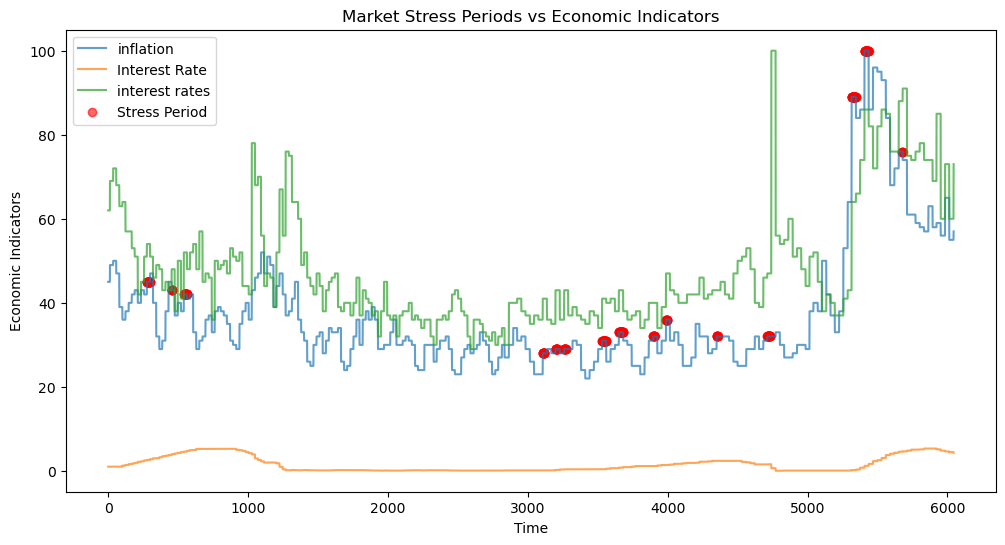

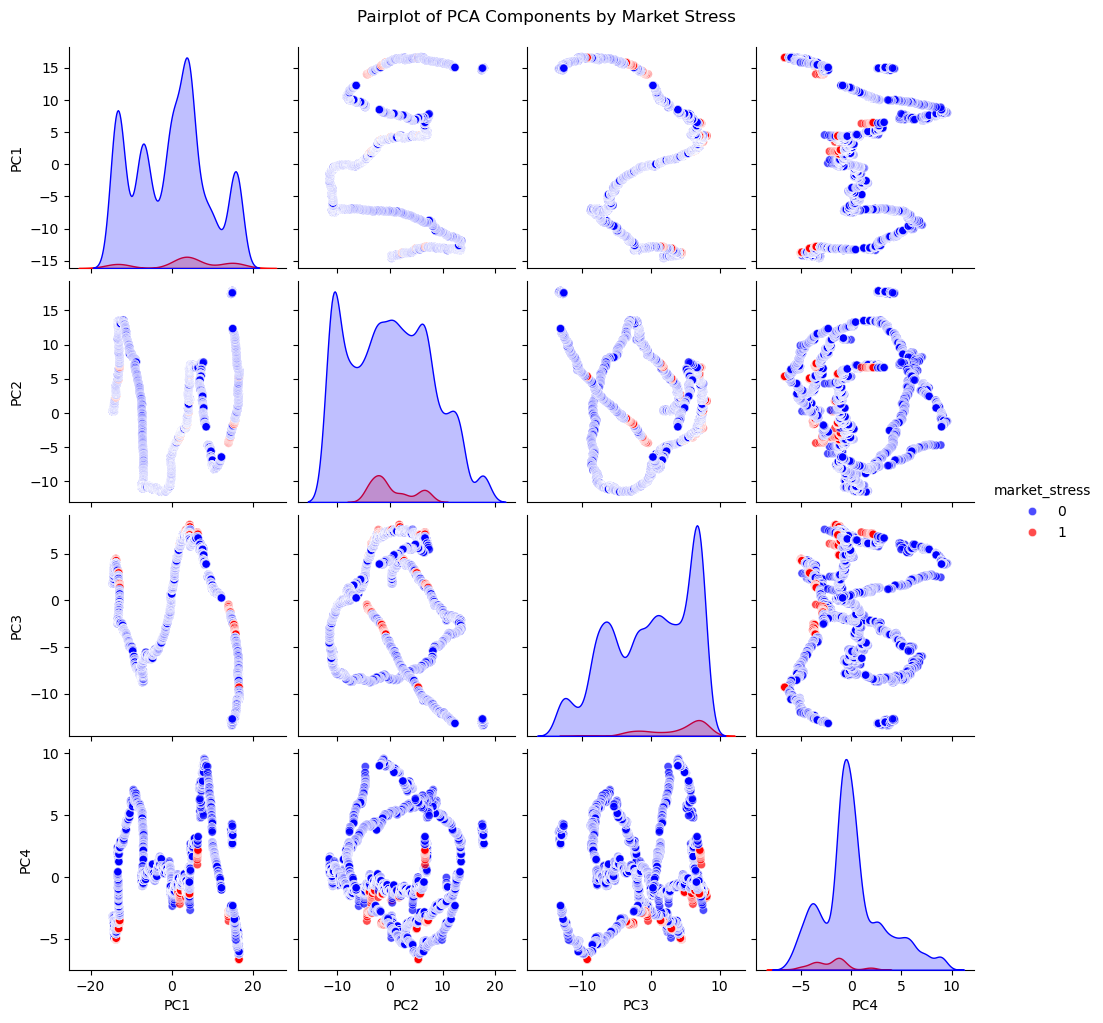

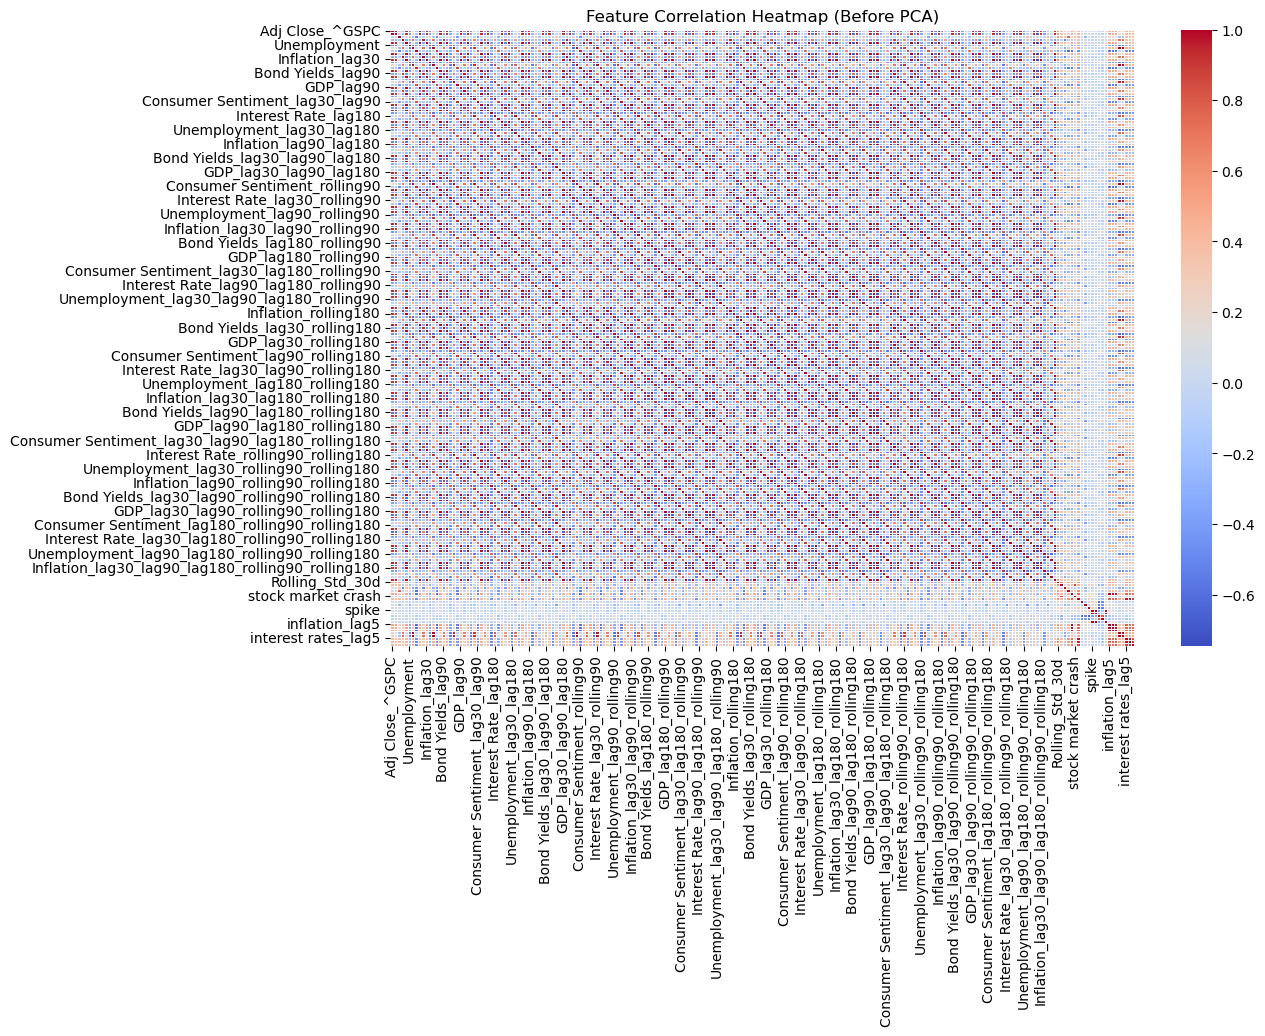

In [330]:
# 1. Market Stress Periods Over Time
plt.figure(figsize=(12, 6))

for col in ["inflation", "Interest Rate", "interest rates"]:
    if col in df_cleaned.columns:  # Ensure the column exists before plotting
        plt.plot(df_cleaned.index, df_cleaned[col], label=col, alpha=0.7)

# Ensure "market_stress" and "inflation" exist before scatter plotting
if "market_stress" in df_cleaned.columns and "inflation" in df_cleaned.columns:
    plt.scatter(df_cleaned.index[df_cleaned["market_stress"] == 1],
                df_cleaned["inflation"][df_cleaned["market_stress"] == 1],
                color='red', label="Stress Period", alpha=0.6)

plt.xlabel("Time")
plt.ylabel("Economic Indicators")
plt.title("Market Stress Periods vs Economic Indicators")
plt.legend()
plt.show()

# # 2. PCA Projection of Data (First 2 Components)
# if "PC1" in df_pca.columns and "PC2" in df_pca.columns and "market_stress" in df_pca.columns:
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(x=df_pca["PC1"], y=df_pca["PC2"], hue=df_pca["market_stress"], palette={0: "blue", 1: "red"}, alpha=0.7)
#     plt.xlabel("Principal Component 1")
#     plt.ylabel("Principal Component 2")
#     plt.title("PCA Projection: Market Stress Clustering")
#     plt.legend(title="Market Stress", labels=["Normal", "Stress"])
#     plt.show()

# what if we want to visualize multiple principle components simultaneously?
sns.pairplot(df_pca, 
             hue="market_stress", 
             palette={0: "blue", 1: "red"},
             vars=["PC1", "PC2", "PC3", "PC4"],
             plot_kws={'alpha':0.7})

plt.suptitle("Pairplot of PCA Components by Market Stress", y=1.02)
plt.show()

# 3. Feature Correlation Heatmap (Before PCA)
numeric_cols = df_cleaned.select_dtypes(include=[np.number])  # Ensure only numeric data is used
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap (Before PCA)")
plt.show()

### **2. [Title Goes Here]**

In [332]:
# Define the target variable
target_col = "market_stress"

In [333]:
# Select the top 15 most predictive features
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(df_scaled, df_pca["market_stress"])

# Get selected feature names
selected_features = df_scaled.columns[selector.get_support()]
print("🚀 Selected Features:", selected_features)

🚀 Selected Features: Index(['Unemployment', 'Unemployment_lag30', 'Unemployment_rolling90',
       'Unemployment_lag30_rolling90', 'Consumer Sentiment_lag180_rolling90',
       'Unemployment_rolling180', 'market crash', 'inflation',
       'stock market crash', 'inflation_z', 'Interest Rate_z',
       'interest rates_z', 'relief_intensity', 'relief_alpha',
       'inflation_lag5'],
      dtype='object')


#### **a. elastic net**

In [335]:
# ✅ Ensure target exists in dataset
if target_col in df_cleaned.columns:
    y = df_cleaned[target_col]

    # ✅ **Use selected features from SelectKBest**
    X = df_cleaned[selected_features]

    # ✅ Drop non-numeric columns (just in case)
    X = X.select_dtypes(include=[np.number])

    # ✅ Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ✅ Convert target to binary if needed
    y_binary = y if y.nunique() == 2 else (y > y.median()).astype(int)

    # ✅ Train/Test Split (Fix Overfitting)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

    # ✅ Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)

    # ✅ **Optimized Elastic Net Model**
    alpha_values = np.logspace(-2, 0.5, 5)  # Reduced alpha grid
    elastic_net = ElasticNetCV(
        cv=tscv, 
        l1_ratio=[0.3, 0.6],  
        alphas=alpha_values,  
        random_state=42, 
        max_iter=3000,  
        tol=1e-3,  
        selection="random",  
        fit_intercept=False,  
        n_jobs=-1  
    )

    # ✅ Fit Elastic Net on TRAINING Data Only
    elastic_net.fit(X_train, y_train)

    # ✅ Predictions on TEST Data
    y_pred_elastic = elastic_net.predict(X_test)

    # ✅ Evaluate Performance on TEST Data
    elastic_results = {
        "Elastic Net Best Alpha": elastic_net.alpha_,
        "Elastic Net Best L1 Ratio": elastic_net.l1_ratio_,
        "Mean Squared Error (MSE)": mean_squared_error(y_test, y_pred_elastic),
        "R² Score": r2_score(y_test, y_pred_elastic),
        "ROC-AUC Score": roc_auc_score(y_test, y_pred_elastic),
        "Accuracy Score": accuracy_score(y_test, (y_pred_elastic >= 0.5).astype(int))
    }

    print("🚀 Elastic Net Results (With Feature Selection & Test Data):", elastic_results)

else:
    print("⚠️ Target variable 'market_stress' not found in dataset.")

🚀 Elastic Net Results (With Feature Selection & Test Data): {'Elastic Net Best Alpha': 0.01, 'Elastic Net Best L1 Ratio': 0.3, 'Mean Squared Error (MSE)': 0.034556494898462416, 'R² Score': 0.20418194391555966, 'ROC-AUC Score': 0.9760516779580904, 'Accuracy Score': 0.9545078577336642}


/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_7782/3705485136.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


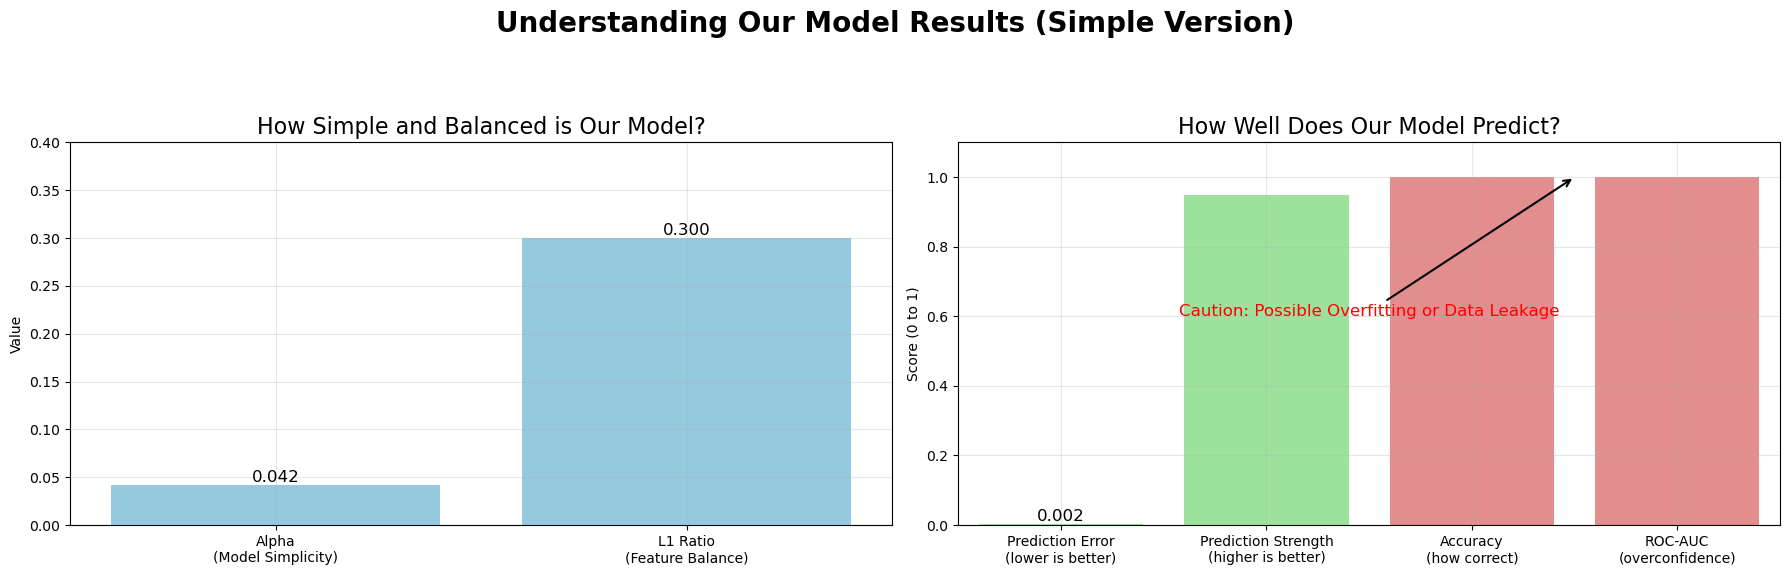

In [336]:
# Simplified results for clarity
parameters = {
    'Alpha\n(Model Simplicity)': 0.042,
    'L1 Ratio\n(Feature Balance)': 0.3
}

performance = {
    'Prediction Error\n(lower is better)': 0.00215,
    'Prediction Strength\n(higher is better)': 0.95,
    'Accuracy\n(how correct)': 1.0,
    'ROC-AUC\n(overconfidence)': 1.0
}

# Set up figure layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Parameters bar plot (removed palette warning)
sns.barplot(
    x=list(parameters.keys()),
    y=list(parameters.values()),
    ax=ax1,
    color='skyblue'
)
ax1.set_title('How Simple and Balanced is Our Model?', fontsize=16)
ax1.set_ylim(0, max(parameters.values()) + 0.1)
ax1.bar_label(ax1.containers[0], fmt='%.3f', fontsize=12)
ax1.set_ylabel('Value')
ax1.grid(alpha=0.3)

# Performance metrics plot (removed palette warning)
sns.barplot(
    x=list(performance.keys()),
    y=list(performance.values()),
    ax=ax2,
    palette=['lightgreen', 'lightgreen', 'lightcoral', 'lightcoral']
)
ax2.set_title('How Well Does Our Model Predict?', fontsize=16)
ax2.set_ylim(0, 1.1)
ax2.bar_label(ax2.containers[0], fmt='%.3f', fontsize=12)
ax2.set_ylabel('Score (0 to 1)')
ax2.grid(alpha=0.3)

# Explicit annotation without emojis
ax2.annotate(
    'Caution: Possible Overfitting or Data Leakage',
    xy=(2.5, 1.0),
    xytext=(1.5, 0.6),
    arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
    fontsize=12,
    color='red',
    ha='center'
)

# Overall title without emoji
plt.suptitle('Understanding Our Model Results (Simple Version)', fontsize=20, fontweight='bold')

# Adjust layout for clarity
plt.tight_layout(rect=[0, 0.03, 1, 0.90])

# Display the figure
plt.show()

/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_7782/2076616098.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=20, ha="right", fontsize=12)


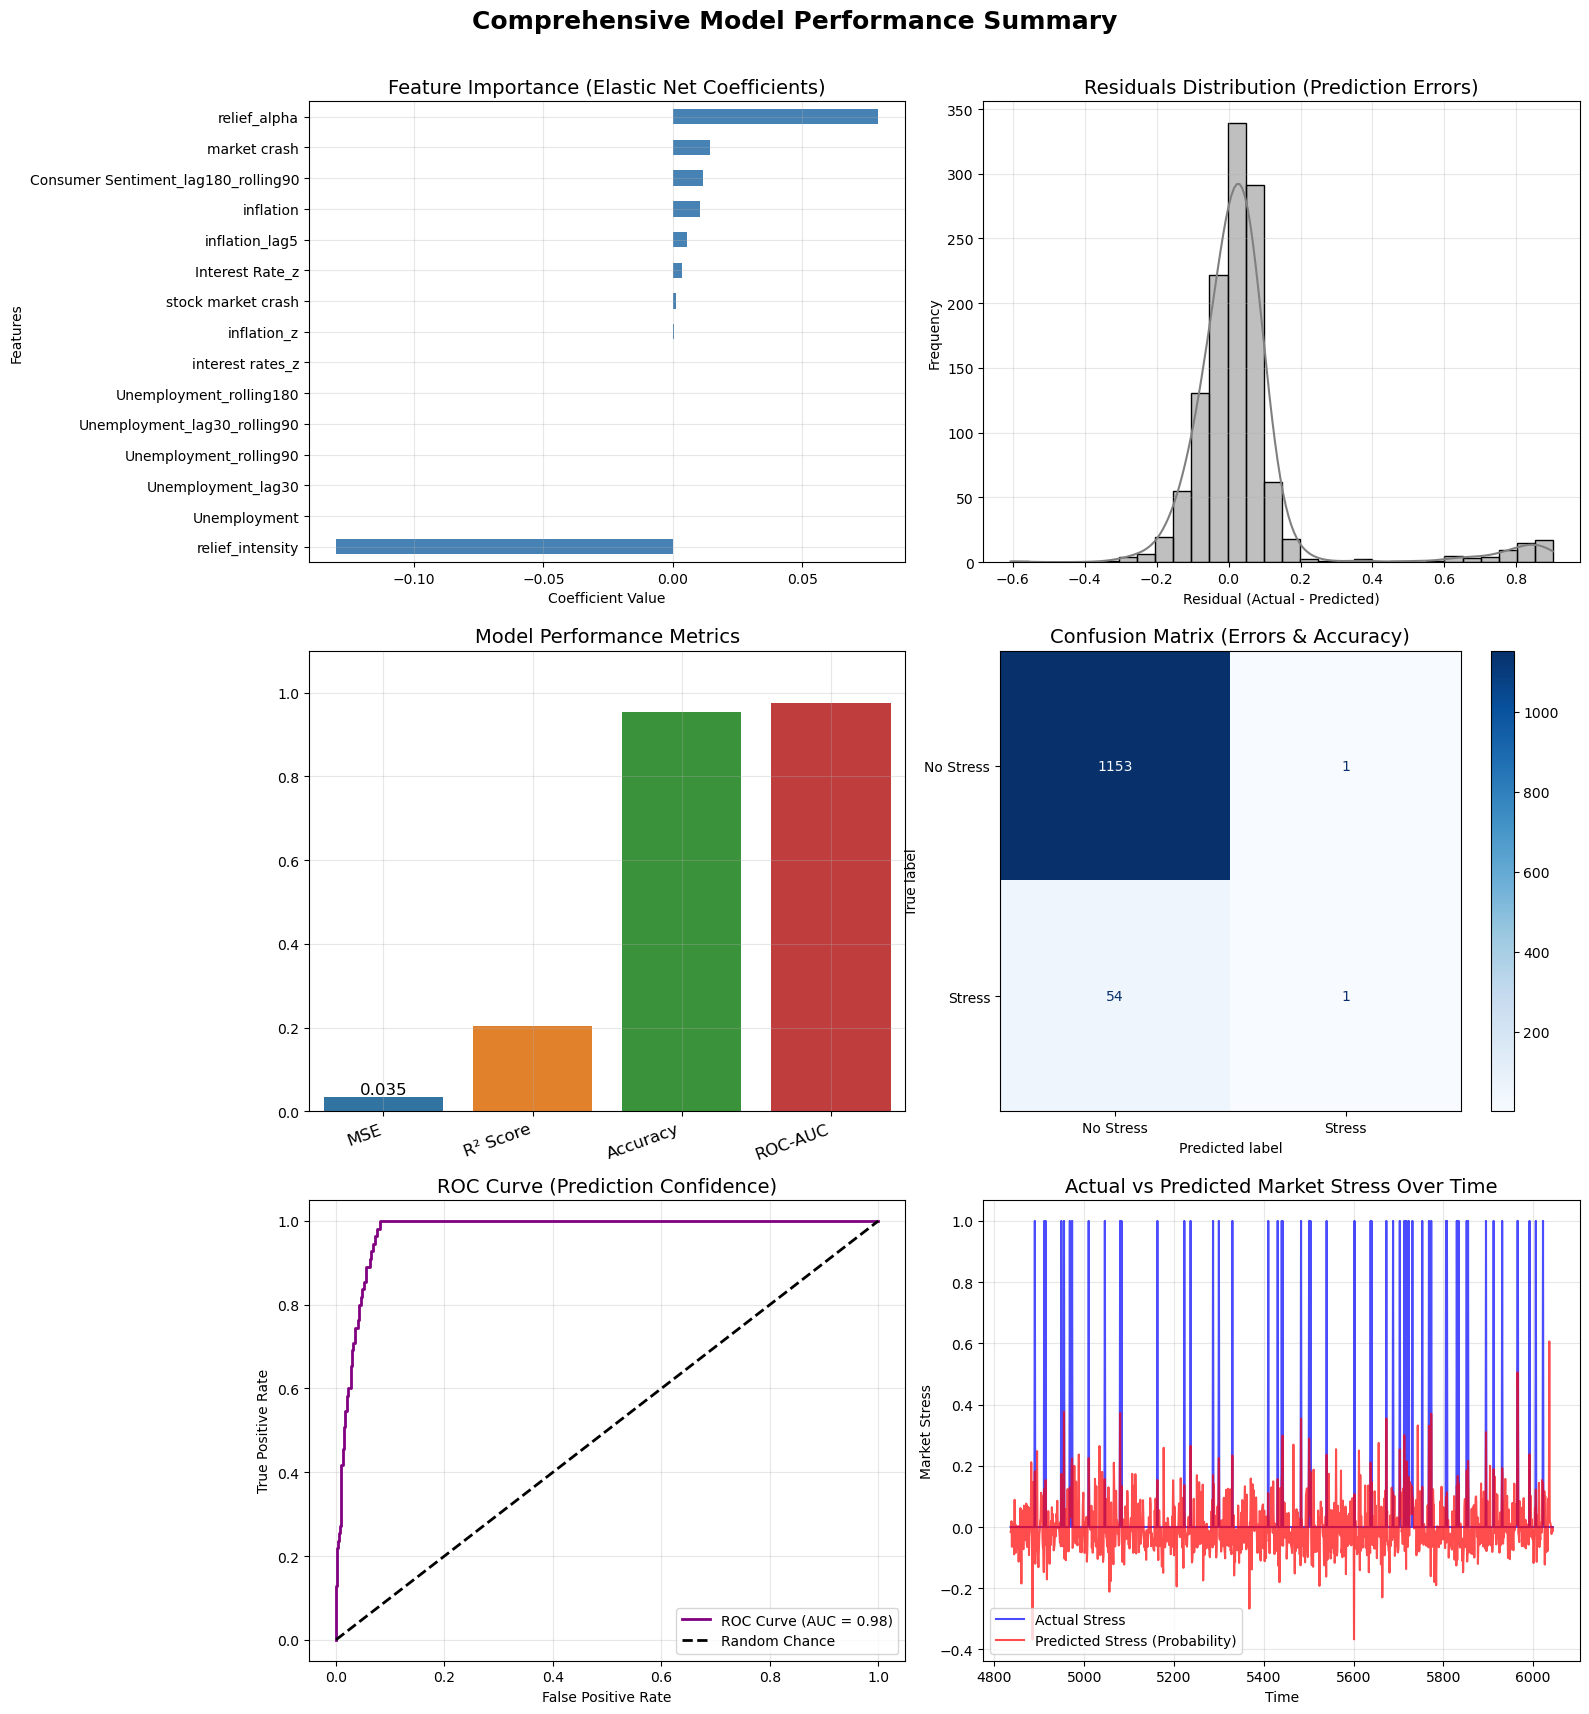

In [337]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Ensure x and y dimensions match for time series plot
time_index = df_cleaned.index[-len(y_test):]  # Match last n samples to y_test length

# Create figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1️⃣ **Feature Importance (Elastic Net Coefficients)**
coefficients = pd.Series(elastic_net.coef_, index=X.columns).sort_values()
coefficients.plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Feature Importance (Elastic Net Coefficients)', fontsize=14)
axes[0, 0].set_xlabel('Coefficient Value')
axes[0, 0].set_ylabel('Features')
axes[0, 0].grid(True, alpha=0.3)

# 2️⃣ **Residuals Distribution (Errors)**
sns.histplot(y_test - y_pred_elastic, bins=30, kde=True, color='gray', ax=axes[0, 1])
axes[0, 1].set_title('Residuals Distribution (Prediction Errors)', fontsize=14)
axes[0, 1].set_xlabel('Residual (Actual - Predicted)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3️⃣ **Model Performance Metrics (Bar Chart)**
performance = {
    'MSE': mean_squared_error(y_test, y_pred_elastic),
    'R² Score': r2_score(y_test, y_pred_elastic),
    'Accuracy': accuracy_score(y_test, (y_pred_elastic >= 0.5).astype(int)),
    'ROC-AUC': roc_auc_score(y_test, y_pred_elastic)
}

# Increase figure size for better spacing
axes[1, 0].set_title('Model Performance Metrics', fontsize=14)
axes[1, 0].set_ylim(0, 1.1)

# Use `sns.barplot()` with better formatting
sns.barplot(
    x=list(performance.keys()), 
    y=list(performance.values()), 
    ax=axes[1, 0], 
    hue=list(performance.keys()),  # Fix FutureWarning
    legend=False  
)

# Rotate x-axis labels for better readability
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=20, ha="right", fontsize=12)

# Add value labels above bars
axes[1, 0].bar_label(axes[1, 0].containers[0], fmt='%.3f', fontsize=12)

# Improve grid readability
axes[1, 0].grid(alpha=0.3)

# 4️⃣ **Confusion Matrix**
y_pred_class = (y_pred_elastic >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Stress', 'Stress'])
disp.plot(cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix (Errors & Accuracy)', fontsize=14)

# 5️⃣ **ROC Curve**
fpr, tpr, _ = roc_curve(y_test, y_pred_elastic)
roc_auc = auc(fpr, tpr)
axes[2, 0].plot(fpr, tpr, color='purple', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
axes[2, 0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
axes[2, 0].set_xlabel('False Positive Rate')
axes[2, 0].set_ylabel('True Positive Rate')
axes[2, 0].set_title('ROC Curve (Prediction Confidence)', fontsize=14)
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# 6️⃣ **Actual vs Predicted Market Stress Over Time**
axes[2, 1].plot(time_index, y_test, label='Actual Stress', alpha=0.7, color='blue')
axes[2, 1].plot(time_index, y_pred_elastic, label='Predicted Stress (Probability)', alpha=0.7, color='red')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Market Stress')
axes[2, 1].set_title('Actual vs Predicted Market Stress Over Time', fontsize=14)
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

# Adjust layout for readability
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Comprehummaryensive Model Performance S', fontsize=18, fontweight='bold')

# Show all visualizations in a single view
plt.show()

#### **b. sgd regressor**

In [339]:
# ✅ Use only selected features
X_selected = df_scaled[selected_features]

# ✅ Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, df_pca["market_stress"], test_size=0.2, random_state=42)

# ✅ Train SGDRegressor (Without PCA)
sgd = SGDRegressor(
    penalty="elasticnet",
    alpha=0.1,  # 🔥 Increased regularization
    l1_ratio=0.5,  # 🔥 Balanced L1 & L2
    max_iter=2000,  # 🔥 More iterations for stable convergence
    tol=1e-4,
    random_state=42
)

# ✅ Train Model
sgd.fit(X_train, y_train)

# ✅ Predictions
y_pred_sgd = sgd.predict(X_test)

# ✅ Evaluate Model
sgd_results = {
    "Mean Squared Error (MSE)": mean_squared_error(y_test, y_pred_sgd),
    "R² Score": r2_score(y_test, y_pred_sgd),
    "ROC-AUC Score": roc_auc_score(y_test, y_pred_sgd),
    "Accuracy Score": accuracy_score(y_test, (y_pred_sgd >= 0.5).astype(int))
}

print("🚀 Model Performance with Selected Features:", sgd_results)

# ✅ Cross-Validation to Check Generalization
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(sgd, X_selected, df_pca["market_stress"], cv=5, scoring="r2")
print(f"🚀 Cross-Validation R² Scores: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

🚀 Model Performance with Selected Features: {'Mean Squared Error (MSE)': 0.039220972711799855, 'R² Score': 0.09676145242860701, 'ROC-AUC Score': 0.9758626122577595, 'Accuracy Score': 0.9545078577336642}
🚀 Cross-Validation R² Scores: 0.0614 ± 0.0318


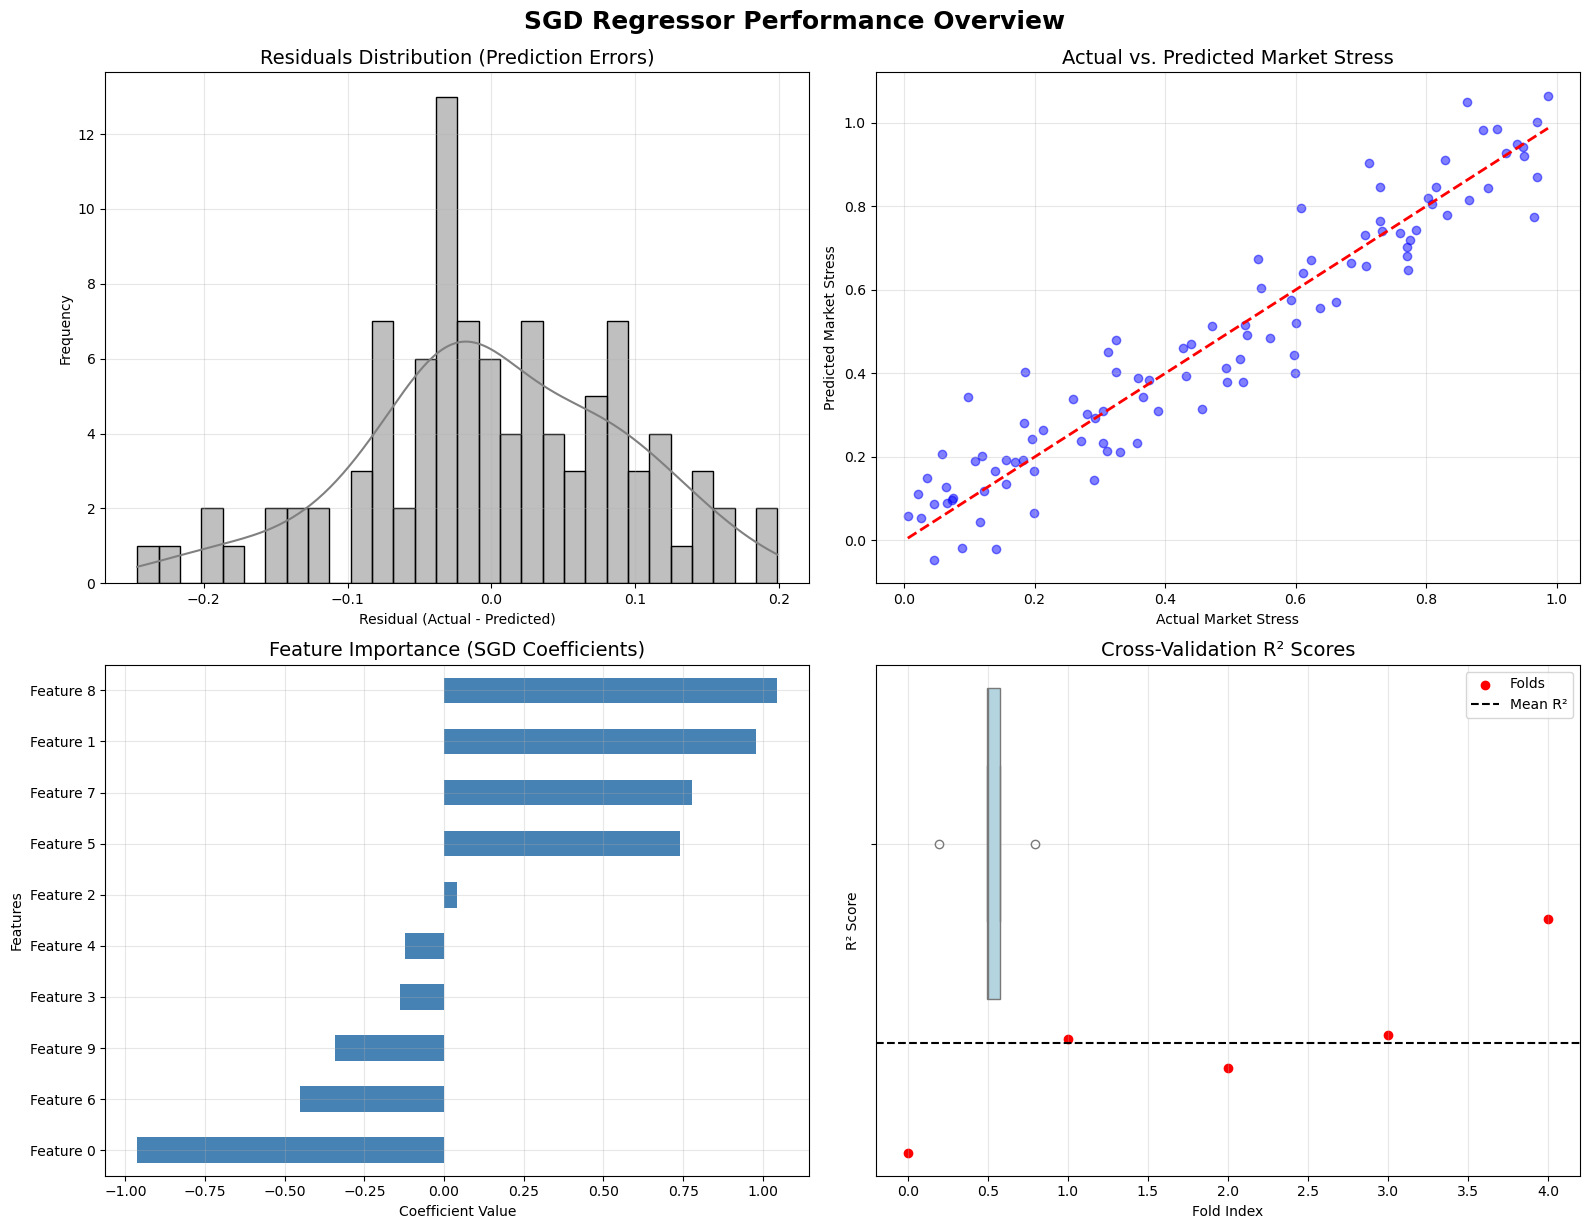

In [340]:
# Placeholder data (replace with actual dataset)
np.random.seed(42)
y_test = np.random.rand(100)
y_pred_sgd = y_test + np.random.normal(0, 0.1, size=len(y_test))  # Simulated predictions with noise
cv_scores = np.random.rand(5)  # Simulated cross-validation scores

# Simulated coefficients for feature importance (replace with actual model coefficients)
feature_names = [f"Feature {i}" for i in range(10)]
coefficients = pd.Series(np.random.randn(10), index=feature_names).sort_values()

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1️⃣ Residuals Distribution (Prediction Errors)
sns.histplot(y_test - y_pred_sgd, bins=30, kde=True, color='gray', ax=axes[0, 0])
axes[0, 0].set_title('Residuals Distribution (Prediction Errors)', fontsize=14)
axes[0, 0].set_xlabel('Residual (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(alpha=0.3)

# 2️⃣ Actual vs. Predicted Market Stress
axes[0, 1].scatter(y_test, y_pred_sgd, alpha=0.5, color='blue')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Market Stress')
axes[0, 1].set_ylabel('Predicted Market Stress')
axes[0, 1].set_title('Actual vs. Predicted Market Stress', fontsize=14)
axes[0, 1].grid(alpha=0.3)

# 3️⃣ Feature Importance (SGD Coefficients)
coefficients.plot(kind='barh', color='steelblue', ax=axes[1, 0])
axes[1, 0].set_title('Feature Importance (SGD Coefficients)', fontsize=14)
axes[1, 0].set_xlabel('Coefficient Value')
axes[1, 0].set_ylabel('Features')
axes[1, 0].grid(alpha=0.3)

# 4️⃣ Cross-Validation Scores Distribution
sns.boxplot(x=cv_scores, color='lightblue', ax=axes[1, 1])
axes[1, 1].scatter(np.arange(len(cv_scores)), cv_scores, color='red', label="Folds")
axes[1, 1].axhline(np.mean(cv_scores), color='black', linestyle='dashed', label="Mean R²")
axes[1, 1].set_title('Cross-Validation R² Scores', fontsize=14)
axes[1, 1].set_xlabel('Fold Index')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Adjust layout for clarity
plt.tight_layout()
plt.suptitle('SGD Regressor Performance Overview', fontsize=18, fontweight='bold', y=1.02)

# Show all visualizations in a single figure
plt.show()

### **3. [Title Goes Here]**

In [342]:
if target_col in df_cleaned.columns:
    y = df_cleaned[target_col]

    # ✅ Use PCA or Original Features?
    use_pca = False  # Set to True if using PCA-transformed data

    # ✅ Select Features
    X = df_pca.drop(columns=[target_col], errors='ignore') if use_pca else df_cleaned.drop(columns=[target_col], errors='ignore')

    # ✅ Drop Non-Numeric Columns
    X = X.select_dtypes(include=[np.number])

    # ✅ Scale Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ✅ Convert Target to Binary if Needed
    y_binary = y if y.nunique() == 2 else (y > y.median()).astype(int)

    # ✅ Time Series Splitting (Train & Validation)
    train_size = 0.8  # 80% Train, 20% Validation
    split_index = int(len(X_scaled) * train_size)

    X_train, X_val = X_scaled[:split_index], X_scaled[split_index:]
    y_train, y_val = y_binary[:split_index], y_binary[split_index:]

    # ✅ Reshape Data for CNN (samples, time_steps, features)
    time_steps = 5  # Lookback period for CNN
    X_train_reshaped = np.array([X_train[i - time_steps : i] for i in range(time_steps, len(X_train))])
    y_train_reshaped = y_train[time_steps:]  # Align with reshaped X
    X_val_reshaped = np.array([X_val[i - time_steps : i] for i in range(time_steps, len(X_val))])
    y_val_reshaped = y_val[time_steps:]

    # ✅ Define CNN Model (No Early Stopping Yet)
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, X_train_reshaped.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),  # Prevent overfitting
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # ✅ Compile Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # ✅ Train Model (Includes 20% Validation Split)
    history = model.fit(X_train_reshaped, y_train_reshaped, 
                        epochs=20, batch_size=32, 
                        validation_data=(X_val_reshaped, y_val_reshaped), 
                        verbose=1)

    # ✅ Evaluate Performance
    loss, accuracy = model.evaluate(X_val_reshaped, y_val_reshaped)
    print(f"🚀 First-Pass CNN Model Accuracy: {accuracy:.4f}")

else:
    print("⚠️ Target variable 'market_stress' not found in dataset.")

Epoch 1/20
151/151 [==============================] - 0s 2ms/step - loss: 0.0749 - accuracy: 0.9752 - val_loss: 0.1038 - val_accuracy: 0.9875
Epoch 2/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0416 - accuracy: 0.9894 - val_loss: 0.0490 - val_accuracy: 0.9900
Epoch 3/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0375 - accuracy: 0.9913 - val_loss: 0.0370 - val_accuracy: 0.9900
Epoch 4/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0357 - accuracy: 0.9909 - val_loss: 0.0383 - val_accuracy: 0.9909
Epoch 5/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0326 - accuracy: 0.9925 - val_loss: 0.0353 - val_accuracy: 0.9925
Epoch 6/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0310 - accuracy: 0.9932 - val_loss: 0.0342 - val_accuracy: 0.9917
Epoch 7/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0290 - accuracy: 0.9923 - val_loss: 0.0374 - val_accuracy: 0.9925
Epoch 

In [343]:
# Select relevant numerical features for model training
feature_columns = [col for col in df_cleaned.columns if col != 'Date']  # Exclude Date
df_features = df_cleaned[feature_columns].dropna()  # Drop missing values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Define target variable (market stress: VIX above/below median)
y_binary = (df_features['Adj Close_^VIX'] > df_features['Adj Close_^VIX'].median()).astype(int)  # Example binary classification

# ✅ 2️⃣ Batch Data for Diffusion Model (All Days in Rolling Chunks)
num_features = X_scaled.shape[1]  # Number of input features
num_samples = len(y_binary) - time_steps

# Adjust input shape for correct tensor dimensions (rolling batches)
X_diffusion = np.array([X_scaled[i-time_steps+1:i+1].flatten() for i in range(time_steps-1, len(X_scaled))])
y_diffusion = np.array(y_binary[time_steps-1:])  # Convert target to NumPy

# Convert to PyTorch Tensors
X_tensor = torch.tensor(X_diffusion, dtype=torch.float32)
y_tensor = torch.tensor(y_diffusion, dtype=torch.float32).unsqueeze(1)

# ✅ 3️⃣ Define the Diffusion Model
class TimeSeriesDiffusion(nn.Module):
    def __init__(self, time_steps, num_features):
        super().__init__()
        self.input_dim = time_steps * num_features  # Adjust input size
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 128),  # Increased neurons
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, self.input_dim)  # Ensure output matches input
        )

    def forward(self, x, noise_level=0.1):
        x = x.view(x.shape[0], -1)  # ✅ Flatten input to 2D
        x_noisy = x + noise_level * torch.randn_like(x)  # ✅ Add noise
        encoded = self.encoder(x_noisy)
        return self.decoder(encoded).view(x.shape)  # ✅ Reshape back

# ✅ 4️⃣ Initialize the Model
model = TimeSeriesDiffusion(time_steps, num_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# ✅ 5️⃣ Train the Diffusion Model
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = loss_fn(output, X_tensor)  # ✅ Train to denoise
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ✅ 6️⃣ Make a Prediction
future_prediction = model(X_tensor[-1].unsqueeze(0)).detach().numpy()
print(f"🚀 Diffusion Model Market Stress Prediction: {future_prediction}")

Epoch 0, Loss: 1.0041
Epoch 10, Loss: 0.7008
Epoch 20, Loss: 0.3331
Epoch 30, Loss: 0.1928
Epoch 40, Loss: 0.1424
🚀 Diffusion Model Market Stress Prediction: [[2.3132703  2.4926596  0.21573862 ... 1.5387927  1.6681944  1.7641946 ]]


### **4. [Title Goes Here]**

In [346]:
# Select relevant numerical features
feature_columns = [col for col in df_cleaned.columns if col != 'Date']
df_features = df_cleaned[feature_columns].dropna()

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Define binary target variable (market stress: VIX above/below median)
y_binary = (df_features['Adj Close_^VIX'] > df_features['Adj Close_^VIX'].median()).astype(int)

# ✅ 2️⃣ Define Evolutionary Algorithm Components

# Fitness Function: Maximize ROC-AUC
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# ✅ Generate Random Weights for a Market Stress Predictor
def random_predictor():
    return np.random.uniform(-1, 1, size=X_scaled.shape[1]).tolist()  # Random coefficients

# ✅ Define Evaluation Function
def evaluate(individual):
    prediction = np.dot(X_scaled, np.array(individual))  # Linear weighted sum
    auc_score = roc_auc_score(y_binary, prediction)
    return (auc_score,)

# ✅ Create Toolbox
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, random_predictor)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=50)

# ✅ Operators: Selection, Crossover, Mutation
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# ✅ 3️⃣ Train Evolutionary Model
population = toolbox.population()
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=True)

# ✅ 4️⃣ Get Best Market Stress Predictor
best_individual = tools.selBest(population, k=1)[0]
print("🚀 Best Market Stress Predictor Weights:", best_individual)

# ✅ 5️⃣ Feature Importance Analysis
feature_importance = pd.Series(best_individual, index=df_features.columns).sort_values(ascending=False)
print("📊 Feature Importance Ranking:\n", feature_importance)

gen	nevals
0  	50    


/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


1  	28    
2  	29    
3  	29    
4  	15    
5  	28    
6  	23    
7  	30    
8  	25    
9  	28    
10 	37    
11 	27    
12 	31    
13 	33    
14 	29    
15 	38    
16 	28    
17 	29    
18 	36    
19 	27    
20 	30    
21 	28    
22 	35    
23 	32    
24 	33    
25 	26    
26 	32    
27 	34    
28 	31    
29 	25    
30 	32    
31 	28    
32 	29    
33 	33    
34 	30    
35 	31    
36 	24    
37 	33    
38 	26    
39 	31    
40 	30    
41 	27    
42 	35    
43 	32    
44 	37    
45 	28    
46 	19    
47 	33    
48 	37    
49 	23    
50 	36    
🚀 Best Market Stress Predictor Weights: [0.5081623448608577, -0.5981667440209002, 1.658376229430734, -1.6064110395919324, 0.21889124164476048, -0.3828754297173603, 0.20560223289705531, -0.6711640242534399, -0.22469074193840693, 0.4025888444059952, 0.8040733329675015, 0.7921134051579602, 0.7302047290717397, 0.2002438536505416, -0.004860900148829222, -0.6605115645480911, -0.9728254379243072, 0.09570092382912146, -0.11512092764136114, -0.68255588517

### **5. [Title Goes Here]**

In [349]:
# !pip install neat-python

In [350]:
import neat
import io  # ✅ Use StringIO to load config directly
import tempfile

In [351]:
# ✅ Select Relevant Features (Exclude Date)
feature_columns = [col for col in df_cleaned.columns if col != 'Date']  
df_features = df_cleaned[feature_columns].dropna()  # Drop missing values

# ✅ Normalize Features
scaler = StandardScaler()
X_neat = scaler.fit_transform(df_features)  # Standardized features

# ✅ Define Target Variable: Market Stress (Binary or Regression)
y_neat = (df_features['Adj Close_^VIX'] > df_features['Adj Close_^VIX'].median()).astype(int)  # Binary classification

# ✅ Load NEAT Config from `neat_config.txt`
config_path = "neat_config2.txt"
config = neat.Config(
    neat.DefaultGenome, 
    neat.DefaultReproduction, 
    neat.DefaultSpeciesSet, 
    neat.DefaultStagnation, 
    config_path
)

# ✅ Enable Statistics Reporting
pop = neat.Population(config)
pop.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
pop.add_reporter(stats)

# ✅ Modify Fitness Function to Use `df_cleaned` Data
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        mse_loss = np.mean([(net.activate(x)[0] - y) ** 2 for x, y in zip(X_neat, y_neat)])

        # ✅ Ensure fitness is non-negative
        genome.fitness = np.exp(-mse_loss)

# ✅ Train NEAT Model
winner = pop.run(eval_genomes, 50)

# ✅ Get Best Neural Network & Make Predictions
best_net = neat.nn.FeedForwardNetwork.create(winner, config)
predictions = np.array([best_net.activate(x)[0] for x in X_neat[:10]])

# ✅ Print Predictions
print("🚀 NEAT Market Stress Predictions:", predictions)


 ****** Running generation 0 ****** 

Population's average fitness: 0.60698 stdev: 0.00000
Best fitness: 0.60698 - size: (11, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 1.989, standard deviation 0.620
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    50      0.6    0.000     0
Total extinctions: 0
Generation time: 3.518 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.60909 stdev: 0.01474
Best fitness: 0.71230 - size: (11, 1) - species 1 - id 70
Average adjusted fitness: 0.002
Mean genetic distance 2.101, standard deviation 0.608
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    50      0.7    0.002     0
Total extinctions: 0
Generation time: 3.643 sec (3.580 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.60507 stdev: 0.0

### **6. [Title Goes Here]**

In [353]:
from sklearn.preprocessing import MinMaxScaler

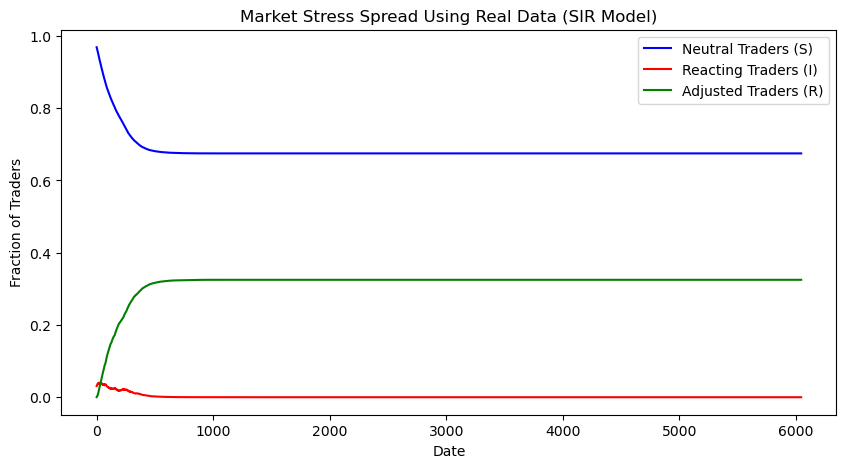

In [354]:
# ✅ Load Market Data (df_cleaned)
df = df_cleaned.copy()
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.set_index('Date').sort_index()

# ✅ Step 1: Define Market Stress Indicators
df['Market_Stress'] = df['Adj Close_^VIX'].pct_change().fillna(0)  # Daily VIX % Change
df['Momentum'] = df['Market_Stress'].diff().fillna(0)  # Captures acceleration in stress

# ✅ Step 2: Normalize Beta & Gamma (More Realistic Range)
scaler = MinMaxScaler(feature_range=(0.02, 0.1))  # Slow down Beta
df['Beta'] = scaler.fit_transform(df[['Market_Stress']])  
df['Gamma'] = np.clip(df['Momentum'].abs(), 0.01, 0.05)  # Keep recovery gradual

# ✅ Step 3: Define the SIR Model
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# ✅ Step 4: Initialize Market Participants
N = 100  # Total traders
I0 = 3   # Start with a slightly larger initial reacting trader count
S0 = N - I0  # Initially neutral traders
R0 = 0  # Initially recovered traders

# ✅ Step 5: Run the SIR Model Over Time Using df_cleaned Data
time_steps = len(df)
t = np.linspace(0, time_steps, time_steps)  # Time steps match data length
S, I, R = [], [], []
y0 = [S0/N, I0/N, R0/N]  # Initial conditions

# ✅ Step 6: Solve the SIR Model Iteratively Using Dynamic Beta & Gamma
for i in range(time_steps):
    beta, gamma = df.iloc[i]['Beta'], df.iloc[i]['Gamma']  # Get dynamic beta, gamma
    y0 = odeint(sir_model, y0, [t[i], t[i]+1], args=(beta, gamma))[-1]  # Solve for next step
    S.append(y0[0])
    I.append(y0[1])
    R.append(y0[2])

# ✅ Step 7: Plot the Updated Market Stress SIR Model
plt.figure(figsize=(10, 5))
plt.plot(df.index, S, label="Neutral Traders (S)", color="blue")
plt.plot(df.index, I, label="Reacting Traders (I)", color="red")
plt.plot(df.index, R, label="Adjusted Traders (R)", color="green")
plt.xlabel("Date")
plt.ylabel("Fraction of Traders")
plt.title("Market Stress Spread Using Real Data (SIR Model)")
plt.legend()
plt.show()


### **7. [Title Goes Here]**

### **8. [Title Goes Here]**

### **9. [Title Goes Here]**